<a href="https://colab.research.google.com/gist/pmeier/4de1ecc9f1370390f712e69a195f5f36/pystiche_ptcv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `pystiche` demo for PTCV

This is a short demo of what `pystiche` can do as part of the PyTorch Community Voices series. If you missed the live stream or just want to watch the presentation again you can access it on [YouTube](https://www.youtube.com/watch?v=lCOjSiHnQwU).

`pystiche` is a library for Neural Style Transfer (NST) build on and fully compatible with PyTorch. In this post we are going to explore the basics. If you want to know more, peruse our [documentation](https://pystiche.readthedocs.io/en/stable/) including a lot of [usage examples](https://pystiche.readthedocs.io/en/stable/galleries/examples/index.html).

In [ ]:
#@title
!pip install pystiche --no-deps &> /dev/null

import re
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=(
        "The (function|parameter) logger is deprecated since pystiche==0.7.0 "
        "and will be removed in a future release. "
        "See https://github.com/pmeier/pystiche/issues/434 for details."
    ),
)
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=(
        re.escape(
            "Named tensors and all their associated APIs are an experimental "
            "feature and subject to change. Please do not use them for "
            "anything important until they are released as stable. (Triggered "
            "internally at  /pytorch/c10/core/TensorImpl.h:1156.)"
        )
    ),
)

import torch
import torch.hub

import pystiche
import pystiche.enc
import pystiche.loss
import pystiche.ops
import pystiche.optim
import pystiche.demo
import pystiche.image

In [ ]:
print(f"pystiche=={pystiche.__version__}")

pystiche==0.7.2.post0


## `MultiLayerEncoder`

The building block that makes NST stand out against other style transfer methods, is the trained rather than hand-crafted feature space. In `pystiche` such a model is called `MultiLayerEncoder`. With it we have convenient access to all intermediate encodings.

In [ ]:
mle = pystiche.enc.vgg19_multi_layer_encoder()
print(mle)

VGGMultiLayerEncoder(
  arch=vgg19, framework=torch
  (preprocessing): TorchPreprocessing(
    (0): Normalize(mean=('0.485', '0.456', '0.406'), std=('0.229', '0.224', '0.225'))
  )
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU()
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3

## `PerceptualLoss`

The heart piece of an NST is the perceptual loss. Its value encodes how well an image fits the content of the content image and the style of the style image. It usually comprises two components, the adversarial `content_loss` and `style_loss`. Let's define them.


In [ ]:
content_loss = pystiche.ops.FeatureReconstructionOperator(
    mle.extract_encoder("relu4_2")
)
print(content_loss)

FeatureReconstructionOperator(
  score_weight=1,
  encoder=VGGMultiLayerEncoder(layer=relu4_2, arch=vgg19, framework=torch)
)


In [ ]:
style_loss = pystiche.ops.MultiLayerEncodingOperator(
    multi_layer_encoder=mle,
    layers=("relu1_1", "relu2_1", "relu3_1", "relu4_1", "relu5_1"),
    get_encoding_op=pystiche.ops.GramOperator,
    score_weight=1e3,
)
print(style_loss)

MultiLayerEncodingOperator(
  encoder=VGGMultiLayerEncoder(arch=vgg19, framework=torch), score_weight=1000
  (relu1_1): GramOperator(score_weight=1)
  (relu2_1): GramOperator(score_weight=1)
  (relu3_1): GramOperator(score_weight=1)
  (relu4_1): GramOperator(score_weight=1)
  (relu5_1): GramOperator(score_weight=1)
)


In [ ]:
perceptual_loss = pystiche.loss.PerceptualLoss(content_loss, style_loss)
perceptual_loss.cuda()
print(perceptual_loss)

PerceptualLoss(
  (content_loss): FeatureReconstructionOperator(
    score_weight=1,
    encoder=VGGMultiLayerEncoder(layer=relu4_2, arch=vgg19, framework=torch)
  )
  (style_loss): MultiLayerEncodingOperator(
    encoder=VGGMultiLayerEncoder(arch=vgg19, framework=torch), score_weight=1000
    (relu1_1): GramOperator(score_weight=1)
    (relu2_1): GramOperator(score_weight=1)
    (relu3_1): GramOperator(score_weight=1)
    (relu4_1): GramOperator(score_weight=1)
    (relu5_1): GramOperator(score_weight=1)
  )
)


## NST with `image_optimization`

At this point we can almost begin with the NST. Before we do that though, we load the target images, namely the `content_image` and `style_image`.

In [ ]:
images = pystiche.demo.images()
content_image = images["bird1"].read(size=500, device="cuda")
style_image = images["paint"].read(size=500, device="cuda")

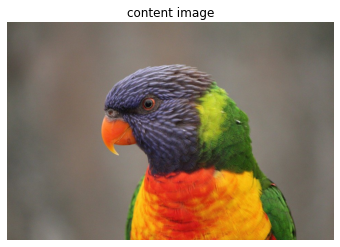

In [ ]:
pystiche.image.show_image(content_image, title="content image")

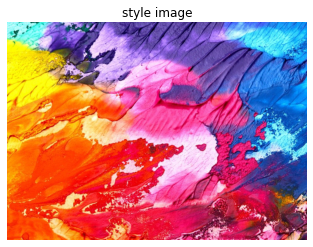

In [ ]:
pystiche.image.show_image(style_image, title="style image")

As a last preliminary step we need to parametrize the `perceptual_loss` with our target images. As `starting_point` we choose the `content_image` above a random one, because this speeds up the convergence.

In [ ]:
perceptual_loss.set_content_image(content_image)
perceptual_loss.set_style_image(style_image)
starting_point = content_image.clone()

Now we are ready to run the NST. It is performed by the `image_optimization` function. It is just a convenience wrapper around a default PyTorch training loop.

In [ ]:
stylized_image = pystiche.optim.image_optimization(
    starting_point, 
    perceptual_loss, 
    num_steps=500, 
    logger=pystiche.demo.logger(),
)

################################################################################
Step 50
################################################################################
  content_loss: 7.437e+00
  style_loss  : 5.217e+02
################################################################################
Step 100
################################################################################
  content_loss: 7.512e+00
  style_loss  : 1.725e+02
################################################################################
Step 150
################################################################################
  content_loss: 7.576e+00
  style_loss  : 1.065e+02
################################################################################
Step 200
################################################################################
  content_loss: 7.602e+00
  style_loss  : 7.534e+01
################################################################################
Step 250
###################

And that's it. We just performed an NST!

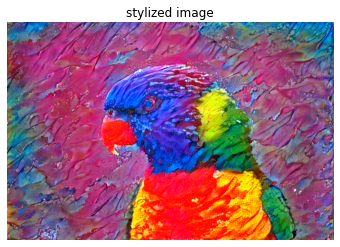

In [ ]:
pystiche.image.show_image(stylized_image, title="stylized image")

## NST with `model_optimization`

NST via `image_optimization` in general leads to the highest quality results. One major downside of the method is that it takes quite some time to run. What if we could train a `transformer` to perform the stylization in a single forward pass? 

In [ ]:
transformer = pystiche.demo.transformer()
print(transformer)

Since training the `transformer` takes a couple of hours, we load pretrained weights. The training process is performed with the same `perceptual_loss` as defined above, albeit parametrized differently. For details see [this example]().

In [ ]:
url = "https://download.pystiche.org/models/example_transformer_ptcv.pth"
state_dict = torch.hub.load_state_dict_from_url(url)

transformer.load_state_dict(state_dict)
_ = transformer.cuda()

The only thing we need to do to perform the NST is to pass the image we want to stylize to the `transformer`.

In [ ]:
input_image = content_image.clone()
output_image = transformer(input_image)

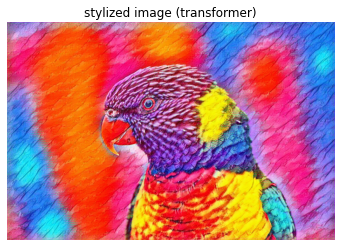

In [ ]:
pystiche.image.show_image(output_image, title="stylized image (transformer)")

That was fast! Let's see *how* fast.

In [ ]:
%%timeit 
transformer(input_image)

10 loops, best of 5: 64.8 ms per loop


Is it feasible to run the `transformer` on the CPU? Let's find out.

In [ ]:
input_image = input_image.cpu()
transformer = transformer.cpu()

In [ ]:
%%timeit
transformer(input_image)

1 loop, best of 5: 2.95 s per loop
